In [3]:
!pip install grid2op

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 47.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.6 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131028 sha256=f60fb937f82e56febe55f8eee905d11ef9c5bf0e866d7e7d32205c30f7536e91
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
Successfully built pandapower


In [4]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 12.5 MB/s eta 0:00:00


In [5]:
!pip install lightsim2grid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.8/853.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 15.2 MB/s eta 0:00:00


In [6]:
pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 26.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


In [7]:
import gymnasium as gym
import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend
import numpy as np
from gymnasium.spaces import Box, Discrete

import matplotlib.pyplot as plt
from stable_baselines3 import DQN

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [8]:
import grid2op
print(grid2op.__version__)

1.10.5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- #### `Initialise` the environment

In [9]:
class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        # DO NOT CHANGE Parameters
        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        # Make grid2op env
        self._g2op_env = grid2op.make(
            self._env_name,
            backend=self._backend,
            test=False,
            action_class=action_class,
            observation_class=observation_class,
            reward_class=reward_class,
            param=p,
        )

        # Set combined reward
        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)
        self._g2op_env.change_reward(cr)

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        # Flatten the observation space
        sample_obs, _ = self._gym_env.reset()
        flat_obs = self.flatten_observation(sample_obs)
        obs_size = flat_obs.shape[0]
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float32)

    def setup_actions(self):
        self.available_actions = []

        # Get the action space from the Grid2Op environment
        action_space = self._g2op_env.action_space

        # Define discrete actions
        # Action 0: Do nothing
        no_op = action_space({})
        gym_no_op = self._gym_env.action_space.to_gym(no_op)
        self.available_actions.append(gym_no_op)

        # Action 1: Open line 0
        open_line_0 = action_space({"set_line_status": [(0, -1)]})
        gym_open_line_0 = self._gym_env.action_space.to_gym(open_line_0)
        self.available_actions.append(gym_open_line_0)

        # Action 2: Close line 0
        close_line_0 = action_space({"set_line_status": [(0, 1)]})
        gym_close_line_0 = self._gym_env.action_space.to_gym(close_line_0)
        self.available_actions.append(gym_close_line_0)

        # Add more actions as needed
        # For example, open/close other lines

        # Update the action space to Discrete
        self.action_space = gym.spaces.Discrete(len(self.available_actions))

    def reset(self, seed=None):
        obs, info = self._gym_env.reset(seed=seed, options=None)
        obs = self.flatten_observation(obs)
        return obs, info

    def step(self, action):
        # Retrieve the Gym-formatted action
        gym_action = self.available_actions[action]

        # Pass the action to the environment
        obs, reward, terminated, truncated, info = self._gym_env.step(gym_action)
        obs = self.flatten_observation(obs)

        # Extract individual rewards
        reward_components = info.get('reward_detail', {})
        print(f"Debug: reward_components extracted: {reward_components}")

        # Check if the expected keys are in the reward components
        if not reward_components or not all(key in reward_components for key in ['L2RPN', 'N1']):
            print("Warning: Reward components missing or incomplete in info.")

        return obs, reward, terminated, truncated, info

    def render(self):
        return self._gym_env.render()

    def flatten_observation(self, obs):
        obs_list = []
        for key in sorted(obs.keys()):
            obs_component = np.array(obs[key]).flatten()
            obs_list.append(obs_component)
        flat_obs = np.concatenate(obs_list).astype(np.float32)
        return flat_obs

- #### `Test` the environment

In [10]:
def test_environment():
    env = Gym2OpEnv()
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    for _ in range(5):
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print("Step result:")
        print("Action taken:", action)
        print("Observation shape:", obs.shape)
        print("Reward:", reward)
        print("Terminated:", terminated)
        if terminated or truncated:
            obs, info = env.reset()

if __name__ == "__main__":
    test_environment()

/usr/local/lib/python3.10/dist-packages/grid2op/MakeEnv/Make.py:506: UserWarning: It is the first time you use the environment "l2rpn_case14_sandbox".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))


downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:23, 12.7MB/s]                           


Extract the tar archive in "/root/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"
	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")
Initial observation shape: (544,)
Initial observation: [ 1.00000000e+00  0.00000000e+00 -2.10994549e+01  2.10760307e+01
  1.75587906e+02  1.59133850e+02  1.03166519e+02  1.69323441e+02
  1.41948868e+02  7.53008728e+01  1.24227509e+02  3.77763977e+02
  2.56653870e+02  6.40643250e+02  8.91682587e+01  2.41787003e+02
  2.65266022e+02  7.39042130e+01  2.86165222e+02  1.19710132e+03
  4.08992706e+02  9.64398865e+02  1.08776270e+03  1.01593530e+03
  1.82659943e+02  1.59208313e+02  1.07515701e+02  1.68930847e+02
  1.41704529e+02  7.25597916e+01  1.24227509e+02  3.77763977e+02
  2.56653870e+02  6.40643250e+02  8.91682587e+01  2.41787003e+02
  2.65266022e+02  

-  #### `Print` observation space and action space

In [11]:
def test_environment():
    env = Gym2OpEnv()

    # Print the action and observation spaces
    print("Action space:", env.action_space)
    print("Number of actions:", env.action_space.n)
    print("Observation space:", env.observation_space)
    print("Observation shape:", env.observation_space.shape)

    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
    print("Initial observation:", obs)

    # Sample a random action
    action = env.action_space.sample()
    print("Sampled action index:", action)
    print("Corresponding action:", env.available_actions[action])

    # Take a step
    obs, reward, terminated, truncated, info = env.step(action)
    print("Observation after action:", obs)
    print("Reward received:", reward)
    print("Terminated:", terminated)
    print("Truncated:", truncated)
    print("Info:", info)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
test_environment()

Action space: Discrete(3)
Number of actions: 3
Observation space: Box(-inf, inf, (544,), float32)
Observation shape: (544,)
Initial observation shape: (544,)
Initial observation: [ 1.00000000e+00 -3.46944695e-16 -2.12398663e+01  2.11460419e+01
  1.49017654e+02  1.32122162e+02  9.37044525e+01  1.43944611e+02
  1.16417061e+02  5.95863152e+01  1.23213104e+02  3.79660522e+02
  2.42644470e+02  6.14634094e+02  9.11710644e+00  1.97500336e+02
  2.71633820e+02  7.25220337e+01  2.81746582e+02  1.02711951e+03
  3.35671631e+02  6.45213623e+02  1.00977576e+03  8.31599792e+02
  1.56084946e+02  1.32375580e+02  9.80504227e+01  1.43667221e+02
  1.16292999e+02  5.64780235e+01  1.23213104e+02  3.79660522e+02
  2.42644470e+02  6.14634094e+02  9.11710644e+00  1.97500336e+02
  2.71633820e+02  7.25220337e+01  2.81746582e+02  1.06544518e+02
  5.02043991e+01  1.00331787e+02  8.65522095e+02  5.82119873e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000

- #### `Test` the environment

In [13]:
def main():
    max_steps = 100
    env = Gym2OpEnv()

    print("#####################")
    print("# OBSERVATION SPACE #")
    print("#####################")
    print(env.observation_space)
    print("#####################\n")

    print("#####################")
    print("#   ACTION SPACE    #")
    print("#####################")
    print(env.action_space)
    print("#####################\n\n")

    curr_step = 0
    curr_return = 0

    is_done = False
    obs, info = env.reset()
    print(f"step = {curr_step} (reset):")
    print(f"\t obs = {obs}")
    print(f"\t info = {info}\n\n")

    while not is_done and curr_step < max_steps:
        # Random action
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)

        curr_step += 1
        curr_return += reward
        is_done = terminated or truncated

        print(f"step = {curr_step}: ")
        print(f"\t obs = {obs}")
        print(f"\t reward = {reward}")
        print(f"\t terminated = {terminated}")
        print(f"\t truncated = {truncated}")
        print(f"\t info = {info}")

        # Checking if action is valid
        is_action_valid = not (info["is_illegal"] or info["is_ambiguous"])
        print(f"\t is action valid = {is_action_valid}")
        if not is_action_valid:
            print(f"\t\t reason = {info['exception']}")
        print("\n")

    print("###########")
    print("# SUMMARY #")
    print("###########")
    print(f"return = {curr_return}")
    print(f"total steps = {curr_step}")
    print("###########")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
  1.35142578e+02  1.24216370e+02  8.39155731e+01  1.35127686e+02
  1.10756187e+02  5.67114067e+01  1.09538544e+02  3.34010345e+02
  2.11008514e+02  5.30520569e+02  2.43698788e+01  1.85317734e+02
  2.38192825e+02  6.16834450e+01  2.58504425e+02  1.00955499e+03
  3.29279236e+02  6.59358215e+02  9.36563843e+02  7.94835144e+02
  1.42206192e+02  1.24712555e+02  8.82569199e+01  1.35181839e+02
  1.10939911e+02  5.41134949e+01  1.09538544e+02  3.34010345e+02
  2.11008514e+02  5.30520569e+02  2.43698788e+01  1.85317734e+02
  2.38192825e+02  6.16834450e+01  2.58504425e+02  1.04722519e+02
  4.92483292e+01  1.02531288e+02  8.02768982e+02  5.56384644e+02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.70000000e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.000

# Agent implementation

In [14]:
class SRAgent:
    def __init__(self, state_size, action_size, gamma=0.99, learning_rate=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        # Successor Representation Network
        self.sr_network = nn.Sequential(
            nn.Linear(state_size + action_size, 128),
            nn.ReLU(),
            nn.Linear(128, state_size)
        )

        # Reward weight vector (no reward_network)
        self.w = nn.Parameter(torch.randn(state_size))

        # Optimizer includes both SR network parameters and w
        self.optimizer = optim.Adam(
            list(self.sr_network.parameters()) + [self.w],
            lr=learning_rate
        )

        self.memory = []

    def get_action(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_size)
        else:
            q_values = []
            state_tensor = torch.FloatTensor(state)
            for action in range(self.action_size):
                action_one_hot = torch.zeros(self.action_size)
                action_one_hot[action] = 1
                sa = torch.cat([state_tensor, action_one_hot])
                psi = self.sr_network(sa)
                # Compute the Q-value using the dot product of psi and w
                q_value = torch.dot(psi, self.w)
                q_values.append(q_value.item())
            return np.argmax(q_values)

    def store_transition(self, transition):
        self.memory.append(transition)

    def train(self, batch_size=64):
        if len(self.memory) < batch_size:
            return

        # Sample a batch
        batch = random.sample(self.memory, batch_size)
        # batch is a list of transitions

        # Extract components
        states = np.array([transition[0] for transition in batch])
        actions = np.array([transition[1] for transition in batch])
        rewards = np.array([transition[2] for transition in batch])
        next_states = np.array([transition[3] for transition in batch])
        dones = np.array([transition[4] for transition in batch])

        # Convert to tensors
        state_tensor = torch.FloatTensor(states)
        next_state_tensor = torch.FloatTensor(next_states)
        reward_tensor = torch.FloatTensor(rewards)
        done_tensor = torch.FloatTensor(dones)

        # One-hot encode actions
        batch_size = actions.shape[0]
        action_tensor = torch.zeros(batch_size, self.action_size)
        action_tensor[np.arange(batch_size), actions] = 1

        # Current state-action pairs
        sa = torch.cat([state_tensor, action_tensor], dim=1)

        # Compute phi(s) (assuming phi(s) = s)
        phi_s = state_tensor

        # Compute psi(s,a)
        psi = self.sr_network(sa)

        # Compute next psi(s', a') for all possible actions a'
        next_psis = []
        next_q_values = []
        for a in range(self.action_size):
            a_one_hot = torch.zeros(batch_size, self.action_size)
            a_one_hot[:, a] = 1
            next_sa = torch.cat([next_state_tensor, a_one_hot], dim=1)
            next_psi = self.sr_network(next_sa)
            q_values = torch.matmul(next_psi, self.w)
            next_psis.append(next_psi)
            next_q_values.append(q_values.unsqueeze(1))

        # Stack q_values to select the best next action
        next_q_values = torch.cat(next_q_values, dim=1)
        max_q_values, max_actions = torch.max(next_q_values, dim=1)

        # Select psi(s', a') corresponding to the best action
        next_psi = torch.stack([next_psis[a][i] for i, a in enumerate(max_actions)], dim=0)

        # Compute psi target
        psi_target = phi_s + self.gamma * next_psi * (1 - done_tensor.unsqueeze(1))

        # Compute SR loss
        sr_loss = nn.MSELoss()(psi, psi_target.detach())

        # Compute reward prediction error
        # Predicted reward: r_pred = phi(s) @ w
        r_pred = torch.matmul(phi_s, self.w)
        reward_loss = nn.MSELoss()(r_pred, reward_tensor)

        # Total loss
        loss = sr_loss + reward_loss

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Training Function:

In [15]:
def train_sr_agent(num_episodes=1000, max_steps=200, batch_size=64):
    env = Gym2OpEnv()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = SRAgent(state_size, action_size)

    all_rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = agent.get_action(state)
            next_state, reward, done, _, info = env.step(action)
            agent.store_transition((state, action, reward, next_state, done))
            agent.train(batch_size=batch_size)

            state = next_state
            total_reward += reward
            if done:
                break

        all_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}")

    # Save the trained agent
    torch.save(agent.sr_network.state_dict(), 'sr_network.pth')
    torch.save(agent.w.detach(), 'reward_weights.pth')

    return agent, all_rewards


Main Execution Block

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [17]:

def plot_rewards(episode_rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(episode_rewards) + 1), episode_rewards, marker='o')
    plt.title('Agent Performance Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


In [18]:
def evaluate_sr_agent(agent, env, num_episodes=10):
    episode_rewards = []
    reward_components_list = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        episode_reward_components = {}
        while not done:
            action = agent.get_action(state, epsilon=0.0)  # No exploration during evaluation
            next_state, reward, done, _, info = env.step(action)
            total_reward += reward

            # Extract and accumulate reward components
            reward_components = info.get('reward_components', {})
            print(f"Debug: reward_components extracted: {reward_components}")

            # Update episode reward components
            for key, value in reward_components.items():
                if key not in episode_reward_components:
                    episode_reward_components[key] = 0.0  # Initialize if not yet present
                episode_reward_components[key] += value

            state = next_state

        episode_rewards.append(total_reward)
        reward_components_list.append(episode_reward_components)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Reward Components Accumulated: {episode_reward_components}")

    return episode_rewards, reward_components_list


In [19]:
from grid2op.Reward import BaseReward

class CustomReward(BaseReward):
    def __init__(self):
        super().__init__()

    def initialize(self, environment):
        self.environment = environment

    def __call__(self, environment, action, done):
        reward = 0.0
        n1_reward = 1.0  # Custom logic for N1 reward component
        l2rpn_reward = 2.0  # Custom logic for L2RPN reward component

        # Store detailed rewards
        self.reward_detail = {
            "N1": n1_reward,
            "L2RPN": l2rpn_reward
        }

        # You can combine them in some way for a total reward, e.g.
        reward = n1_reward + l2rpn_reward
        return reward


In [20]:
def plot_reward_components(reward_components_list):
    episodes = range(1, len(reward_components_list) + 1)

    # Use get() to handle missing keys gracefully
    l2rpn_rewards = [rc.get('L2RPN', 0.0) for rc in reward_components_list]
    n1_rewards = [rc.get('N1', 0.0) for rc in reward_components_list]

    plt.figure(figsize=(12, 6))
    plt.plot(episodes, l2rpn_rewards, label='L2RPN Reward', marker='o')
    plt.plot(episodes, n1_rewards, label='N1 Reward', marker='s')
    plt.title('Reward Components Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


Streaming output truncated to the last 5000 lines.
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward

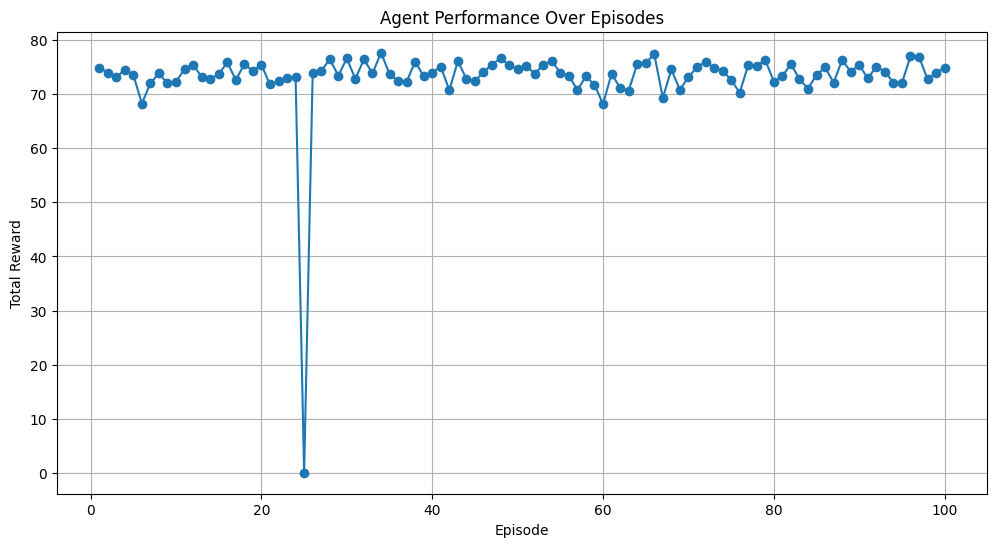

Streaming output truncated to the last 5000 lines.
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward

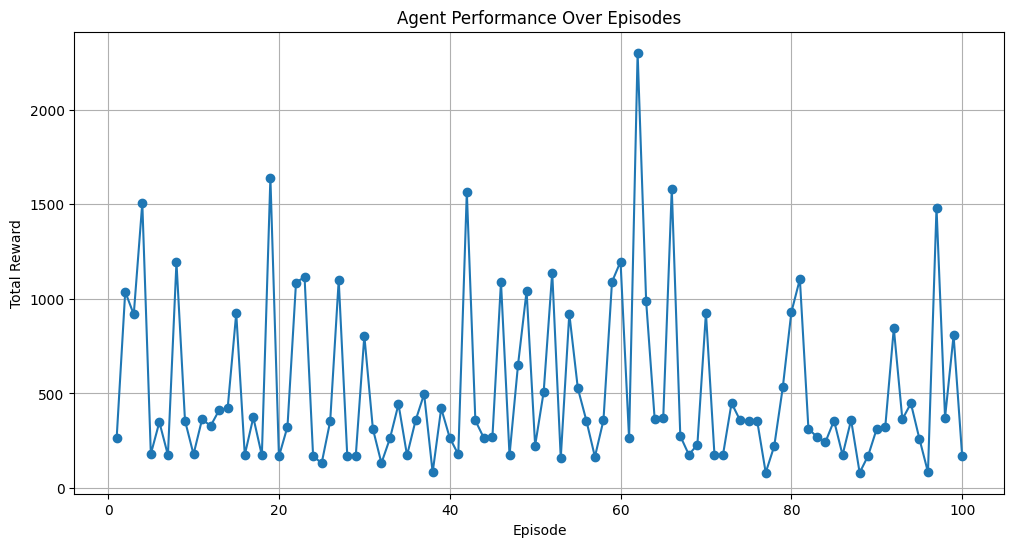

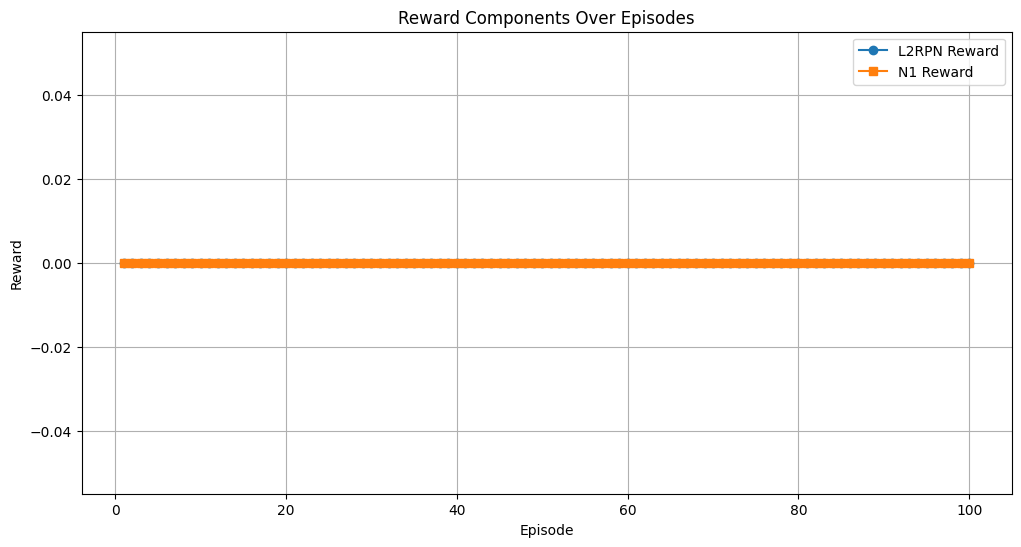

In [21]:
if __name__ == "__main__":
    # Training the SR agent
    agent, training_rewards = train_sr_agent(num_episodes=100)

    # Plot training rewards
    plot_rewards(training_rewards)

    # Evaluate the trained SR agent
    env = Gym2OpEnv()
    num_evaluation_episodes = 50
    rewards, reward_components_list = evaluate_sr_agent(agent, env, num_episodes=num_evaluation_episodes)

    # Plot evaluation rewards
    plot_rewards(rewards)

    # Plot reward components
    plot_reward_components(reward_components_list)


- #### `Visualise` the results

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


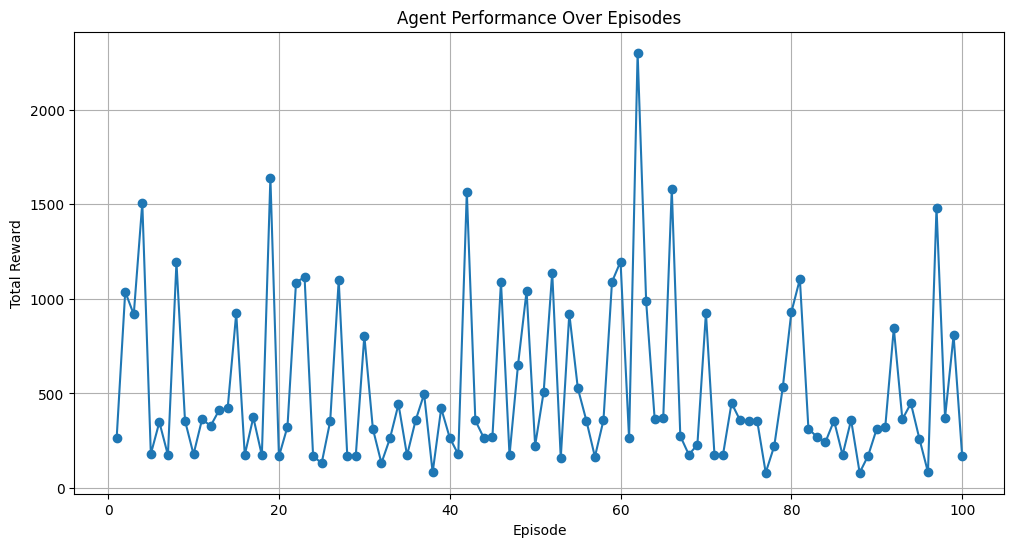

In [22]:
# call plot function
plot_rewards(rewards)

- #### `Extracting` individual reward components (L2RPN & N1)

In [25]:
# Call the Evaluate agent function
rewards, reward_components_list = evaluate_sr_agent(agent, env, num_episodes=num_evaluation_episodes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward_components extracted: {}
Debug: reward

- #### `Visualising` individual reward components (L2RPN & N1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


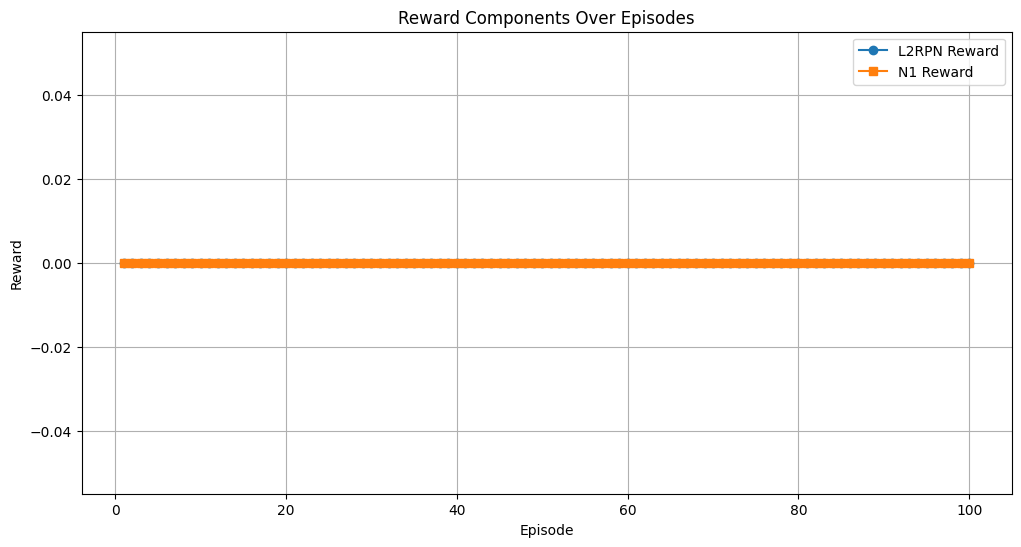

In [26]:
# Call the plot_reward_components
plot_reward_components(reward_components_list)